# WORK IN PROGRESS

- THIS DATA AND THIS MODEL ARE STILL BEING TRANSFORMED AND ASSESSED

In [91]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [93]:
#read in training dataset
df = pd.read_csv("Resources/cpl_train_cleaned.csv")

In [94]:
df.head()

,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23,NaN,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High spent Small value payments,312.494089,Good
1,-500,NaN,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low spent Medium value payments,331.209863,Good
2,23,NaN,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low spent Small value payments,223.451310,Good
3,23,NaN,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High spent Medium value payments,341.489231,Good
4,23,NaN,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,!@9#%8,340.479212,Good


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93465 entries, 0 to 93464
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       93465 non-null  int64  
 1   SSN                       0 non-null      float64
 2   Occupation                93465 non-null  object 
 3   Annual_Income             93465 non-null  float64
 4   Monthly_Inhand_Salary     79447 non-null  float64
 5   Num_Bank_Accounts         93465 non-null  int64  
 6   Num_Credit_Card           93465 non-null  int64  
 7   Interest_Rate             93465 non-null  int64  
 8   Num_of_Loan               93465 non-null  int64  
 9   Type_of_Loan              82959 non-null  object 
 10  Delay_from_due_date       93465 non-null  int64  
 11  Num_of_Delayed_Payment    86910 non-null  float64
 12  Changed_Credit_Limit      91479 non-null  float64
 13  Num_Credit_Inquiries      91642 non-null  float64
 14  Credit

### Some More Cleaning

In [96]:
#investigate nan value of credit history age
df['Credit_History_Age'].unique()

array(['22 Years and 1 Months', '22 Years and 3 Months',
       '22 Years and 4 Months', '22 Years and 5 Months',
       '22 Years and 6 Months', '22 Years and 7 Months', nan,
       '26 Years and 7 Months', '26 Years and 8 Months',
       '26 Years and 10 Months', '26 Years and 11 Months',
       '27 Years and 0 Months', '27 Years and 1 Months',
       '27 Years and 2 Months', '17 Years and 9 Months',
       '17 Years and 10 Months', '17 Years and 11 Months',
       '18 Years and 1 Months', '18 Years and 2 Months',
       '18 Years and 3 Months', '18 Years and 4 Months',
       '17 Years and 3 Months', '17 Years and 4 Months',
       '17 Years and 5 Months', '30 Years and 8 Months',
       '30 Years and 9 Months', '30 Years and 11 Months',
       '31 Years and 0 Months', '31 Years and 1 Months',
       '31 Years and 2 Months', '32 Years and 0 Months',
       '32 Years and 2 Months', '32 Years and 3 Months',
       '32 Years and 5 Months', '32 Years and 6 Months',
       '30 Years and 

In [97]:
#Drop rows with nan value in Credit_Mix
df['Credit_History_Age'] = df['Credit_History_Age'].astype(str)
df = df[df['Credit_History_Age'] != 'nan']

In [98]:
#Investigate empty value in Credit_Mix
df['Credit_Mix'].unique()

array([' ', 'Good', 'Standard', 'Bad'], dtype=object)

In [99]:
#Drop rows with empty value in Credit_Mix
df = df[df['Credit_Mix'] != ' ']

In [100]:
# investigate !@9#%8 value in Payment Behavior
df['Payment_Behaviour'].unique()

array(['Low spent Medium value payments',
       'Low spent Small value payments',
       'High spent Medium value payments', '!@9#%8',
       'High spent Large value payments',
       'High spent Small value payments',
       'Low spent Large value payments'], dtype=object)

In [101]:
#Drop rows with !@9#%8 value in Credit_Mix
df = df[df['Payment_Behaviour'] != '!@9#%8']

### Addressing the numerical columns with null values

- I will go through each numerical column and assess the best imputation method on a case by case basis

In [102]:
#check values of age at brief look at the csv, there appears to be unrealistic ages like negative values
df['Age'].unique()

array([-500,   23,   28, ..., 8425, 4808, 2263], dtype=int64)

In [103]:
#Lets drop any ages less than 0 and greater than 100
df = df[(df['Age'] >= 0) & (df['Age'] <= 100)]

<Axes: ylabel='Frequency'>

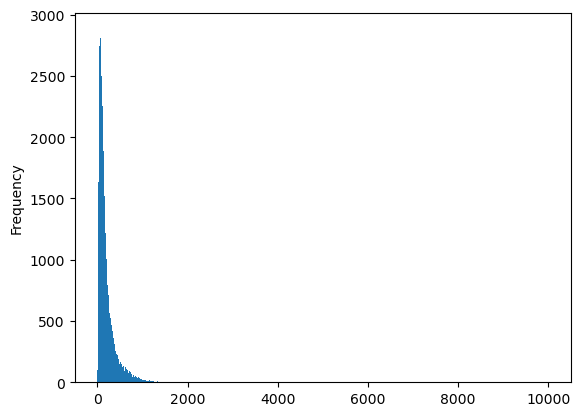

In [104]:
#histogram of feature with null values: Amount_invested_monthly
df['Amount_invested_monthly'].plot(kind='hist', bins = 1000)

In [105]:
# replace null values for the 'Amount_invested_monthly' with median value due to skewed data and outliers
median = df['Amount_invested_monthly'].median()
df['Amount_invested_monthly'].fillna(median, inplace = True)

<Axes: ylabel='Frequency'>

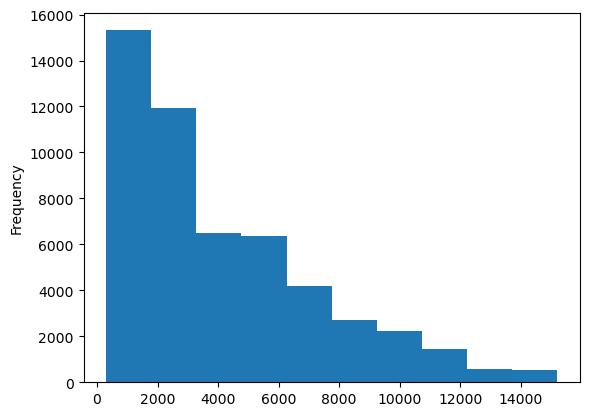

In [106]:
#histogram of feature with null values: Monthly_Inhand_Salary
df['Monthly_Inhand_Salary'].plot(kind='hist')

In [107]:
# replace null values for the 'Monthly_Inhand_Salary' with median value
median = df['Monthly_Inhand_Salary'].median()
df['Monthly_Inhand_Salary'].fillna(median, inplace = True)

4397.0


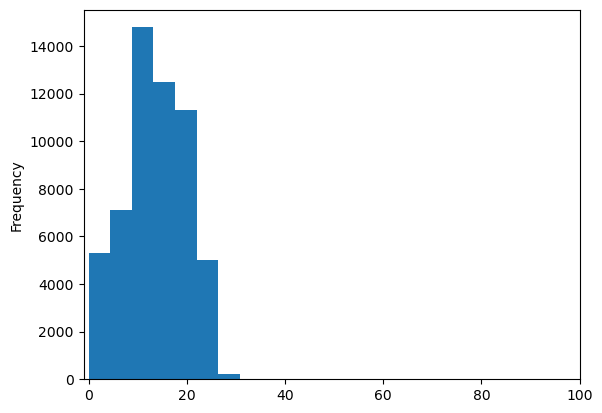

In [108]:
# histogram of feature with null values: Num_of_Delayed_Payment

# initial attempts to plot this histogram showed that it was skewed by a large outlier around at value 'max'
max = df['Num_of_Delayed_Payment'].max()

#set the limits of the graph to not display the outlier
df['Num_of_Delayed_Payment'].plot(kind ='hist', bins = 1000).set_xlim(-1, 100)
print(max)

In [109]:
# due to extremely high outlier in dataset, I will fill na values with the median
median = df['Num_of_Delayed_Payment'].median()
df['Num_of_Delayed_Payment'].fillna(median, inplace = True)

<Axes: ylabel='Frequency'>

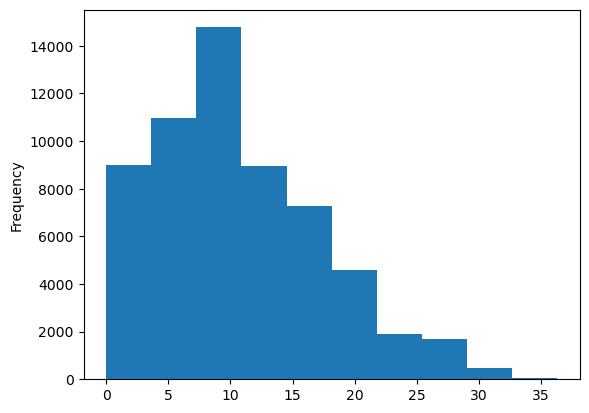

In [110]:
# histogram of feature with null values: Changed_Credit_Limit
df['Changed_Credit_Limit'].plot(kind = 'hist')

In [111]:
# replace null values with median due to skewed histogram
median = df['Changed_Credit_Limit'].median()
df['Changed_Credit_Limit'].fillna(median, inplace = True)

2594.0


(-1.0, 20.0)

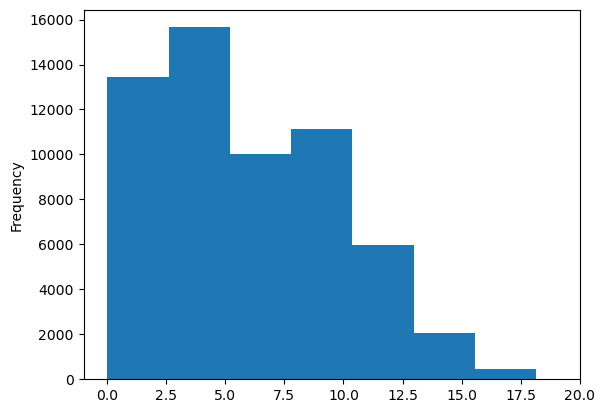

In [112]:
#  plot histogram of feature with null values: Num_Credit_Inquiries

# initial attempts to plot this histogram showed that it was skewed by a large outlier around at value 'max'
max = df['Num_Credit_Inquiries'].max()
print(max)

# set limits of x axis to exclude outlier
df['Num_Credit_Inquiries'].plot(kind = 'hist', bins = 1000).set_xlim(-1, 20)

In [113]:
#data is skewed with outliers so I will replace the na values with the median
median = df['Num_Credit_Inquiries'].median()
df['Num_Credit_Inquiries'].fillna(median, inplace = True)

<Axes: ylabel='Frequency'>

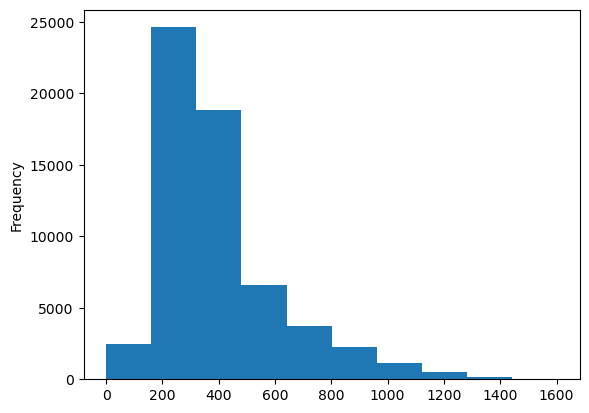

In [114]:
#  plot histogram of feature with null values: Monthly_Balance
df['Monthly_Balance'].plot(kind = 'hist')

In [115]:
#Data is skewed so i will fill na values with the median
median = df['Monthly_Balance'].median()
df['Monthly_Balance'].fillna(median, inplace = True)

### Addressing Categorical Columns
 - I will create dummy variables for categorical data and ordinal encode ordinal categorical data. This will be concacted to df after numerical data scaling.

In [116]:
#drop na values of Type_of_Loan
df['Type_of_Loan'].dropna(axis = 0, inplace = True)

In [117]:
# frequency encoding of categorical variables
type_of_loan_freq = df['Type_of_Loan'].value_counts()
payment_of_min_amount_freq = df['Payment_of_Min_Amount'].value_counts()
payment_behaviour_freq = df['Payment_Behaviour'].value_counts()
occupation_freq = df['Occupation'].value_counts()

In [118]:
#convert Credit_Mix to ordinal numerical column
target_list = ['Bad', 'Standard', 'Good']

df['Credit_Mix'] = pd.Categorical(df['Credit_Mix'], categories= target_list, ordered=True).codes

In [119]:
# convert Credit_History_Age from a string to a count of the months
def convert_to_months(duration_str):
    parts = duration_str.split(' ')
    years = int(parts[0])
    months = int(parts[3])
    total_months = years * 12 + months
    return total_months

df['Credit_History_Age'] = df['Credit_History_Age'].astype(dtype='str').apply(convert_to_months)

In [120]:
#drop SSN column and categorical features that were converted to dummies
df.drop(['SSN', 'Type_of_Loan', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Occupation'], axis = 1, inplace = True)

In [121]:
df['Credit_Score'].value_counts()

Credit_Score
Standard    32631
Poor        17883
Good        10435
Name: count, dtype: int64

In [122]:
#check dataframe
df.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
2,23,19114.12,3088.874167,3,4,3,4,5,4.0,6.27,4.0,2,809.98,31.377862,268,49.574949,199.458074,223.451310,Good
3,23,19114.12,1824.843333,3,4,3,4,6,14.0,11.27,4.0,2,809.98,24.797347,269,49.574949,41.420153,341.489231,Good
5,23,19114.12,1824.843333,3,4,3,4,3,8.0,11.27,4.0,2,809.98,22.537593,271,49.574949,178.344067,244.565317,Good
7,28,34847.84,3037.986667,2,4,6,1,3,4.0,5.42,2.0,2,605.03,24.464031,319,18.816215,104.291825,470.690627,Standard
8,28,34847.84,3037.986667,2,4,6,1,7,1.0,7.42,2.0,2,605.03,38.550848,320,18.816215,40.391238,484.591214,Good


### Transforming the target variable/ splitting dataframe/ scaling data
- I will encode the ordinal below target variable and split the data into training and testing groups. Then I will scale the features.

In [123]:
df['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [124]:
#create ordered list from target column 'Credit_Score'
target_list = ['Poor', 'Standard', 'Good']

In [125]:
#split data into target and features

#This transforms the Credit_Score column into a 0 for poor, 1 for standard, and 2 for good
y = pd.Categorical(df['Credit_Score'], categories= target_list, ordered=True).codes

#create feature only df
X = df.drop(['Credit_Score'], axis = 1)

y

array([2, 2, 2, ..., 1, 0, 1], dtype=int8)

In [126]:
# Concat dummy variable columns with feature df
#X = pd.concat([X,type_of_loan_dummies, payment_of_min_amount_dummies, payment_behaviour_dummies, occupation_dummies], axis = 1)

In [127]:
#split dateset in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [128]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60949 entries, 2 to 93463
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       60949 non-null  int64  
 1   Annual_Income             60949 non-null  float64
 2   Monthly_Inhand_Salary     60949 non-null  float64
 3   Num_Bank_Accounts         60949 non-null  int64  
 4   Num_Credit_Card           60949 non-null  int64  
 5   Interest_Rate             60949 non-null  int64  
 6   Num_of_Loan               60949 non-null  int64  
 7   Delay_from_due_date       60949 non-null  int64  
 8   Num_of_Delayed_Payment    60949 non-null  float64
 9   Changed_Credit_Limit      60949 non-null  float64
 10  Num_Credit_Inquiries      60949 non-null  float64
 11  Credit_Mix                60949 non-null  int8   
 12  Outstanding_Debt          60949 non-null  float64
 13  Credit_Utilization_Ratio  60949 non-null  float64
 14  Credit_Hist

In [129]:
# Creating StandardScaler instance
#scaler = StandardScaler()

# Fitting Standard Scaller
#X_scaler = scaler.fit(X_train)

# Scaling data
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)

In [130]:
# Convert the dataset into DMatrix format, which is a requirement for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Building the XGBOOST
- Below I will fit, predict, score my inital model

In [131]:
# # Initialize the XGBClassifier
# xgb_clf = XGBClassifier(objective='multi:softprob', num_class=3, missing=median, seed=42)

# # Train the model with early stopping
# xgb_clf.fit(
#     X_train,
#     y_train
    # verbose=True,
    # early_stopping_rounds=10,
    # eval_metric='aucpr',
    # eval_set=[(X_test, y_test)]
# )


In [132]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200]
}

In [133]:
# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

In [134]:
# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,  # Use all available cores
    cv=3,  # 3-fold cross-validation
    verbose=1
)

In [135]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.5, 0.7, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [136]:
# Get the best model
best_model = grid_search.best_estimator_

In [137]:
# Make predictions
predictions = best_model.predict(X_test)

In [138]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [139]:
# Fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [140]:
prediction = xgb_model.predict(X_test)

In [141]:
#get confusion matrix
confusion_matrix(y_test, prediction)

array([[3164, 1099,  208],
       [1043, 6342,  773],
       [  54,  785, 1770]], dtype=int64)

In [142]:
#print classification report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      4471
           1       0.77      0.78      0.77      8158
           2       0.64      0.68      0.66      2609

    accuracy                           0.74     15238
   macro avg       0.72      0.72      0.72     15238
weighted avg       0.74      0.74      0.74     15238



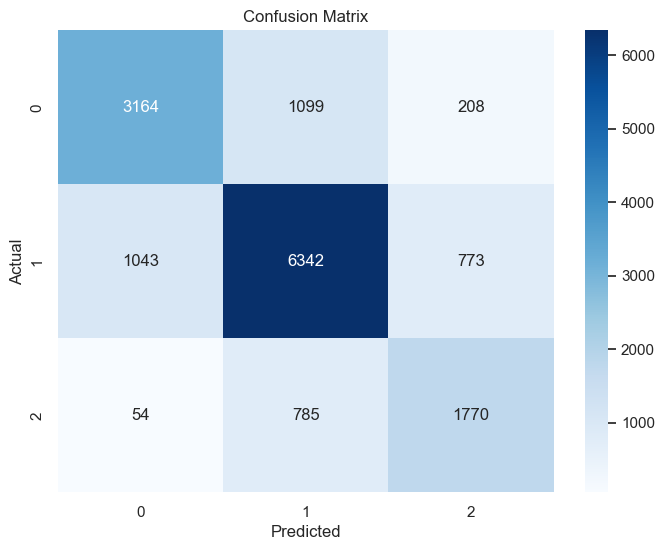

In [143]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, prediction)

# Plot the confusion matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')  # Adjusting Seaborn style
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### ROC and AUC
- Visual for reference

In [149]:
# Predict probabilities
y_score = best_model.predict_proba(X_test)

In [150]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [154]:
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [156]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

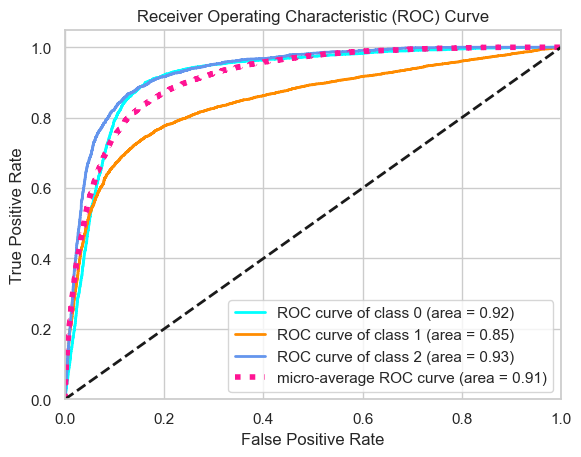

In [157]:
# Plot ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4, color='deeppink',
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Initial Assessment and Fixes
- Accuracy is below goal of ~74%
- Creating training data with an equal amount of observations for each target may improve results.